In [79]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [106]:
######## FUNCTIONS #########

def read_data(shot, silent= False):
    ###FIND MATCHING FILE NAMES
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    kirills_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT"+ str(shot) + "[^0-9]*[0-9]{3}[^0-9].*.csv", file_name))]
    phils_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*{:d}[^0-9]*\.csv".format(shot) , file_name))]
    xray_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT{:d}.tif".format(shot) , file_name))]
    filtered_file_names = kirills_file_names + phils_file_names + xray_file_names
    ###PRINT FILE INFO
    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]
    ###PUT OSCILLOSCOPE FILES INTO DICTIONARY
    dictionary = {}
    for phils_file_name in phils_file_names: # should only be 1 file
        for n, column in enumerate(["time","bdot","tof","diode"]): # some data files have Ch4 but it's just noise.
            dictionary[column] = np.genfromtxt(relitive_path+phils_file_name, delimiter=',', skip_header =18, usecols=n)
    ###PUT THZ FILES INTO DICTIONARY
    for kirill_file_name in kirills_file_names:
        for Ch in ["Ch1","Ch2","Ch3","Ch4"]:
            if Ch in kirill_file_name : channel = Ch # Python has got some weird ways of writing if statements.
        dictionary["pyro_time"], dictionary[channel] = np.genfromtxt(relitive_path+kirill_file_name, delimiter=',', skip_header =0, usecols=(3,4)).T
    ###PUT XRAY FILES INTO DICTIONARY
    for xray_file_name in xray_file_names: # should only be 2 files
        raw = "_raw" if "raw" in xray_file_name else ""
        dictionary["xray" + raw] = np.array(Image.open(relitive_path+xray_file_name))

    return dictionary

def read_lots_of_data(shots, requested_data, silent= False): #read_data is too slow because it reads all files
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    shots = np.array([str(shot) for shot in shots])
    dictionary = {}
    oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    if requested_data in pyro_data:
        channel = "Ch1" if requested_data == "pyro_time" else requested_data
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4)

    elif requested_data in oscilloscope_data:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", file_name))]
        shot_no = [int(re.search("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            column = oscilloscope_data.index(requested_data)
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =18, usecols= column)

    elif requested_data in ["xray", "xray_raw"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+").tif", file_name))]
        raw = [True if "raw" in filtered_file_name else False for filtered_file_name in filtered_file_names]
        if requested_data == "xray":
            filtered_file_names = np.array(filtered_file_names)[np.logical_not(raw)]
        else:
            filtered_file_names = np.array(filtered_file_names)[raw]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+").tif", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.array(Image.open(relitive_path+filtered_file_names[n]))

    elif requested_data == "espec":
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("^IP.*.tif", file_name))]
        #shot number = N/A
        for filtered_file_name in filtered_file_names: # Should be all files as the espec is related to a set of shots as opposed to a single shot.
            dictionary[filtered_file_name] = np.array(Image.open(relitive_path+filtered_file_name))

    else:
        raise ValueError("{0:} is not a recognised data set".format(requested_data))

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return dictionary # dict with the shot number as keys :)


Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif
1144401200.0


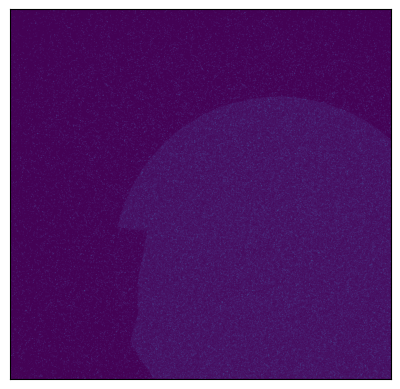

In [118]:
Ximage=read_data(71)["xray"]
Xsumm=np.sum(Ximage)
print(Xsumm)

plt.imshow(Ximage)
plt.xticks([])
plt.yticks([])
plt.show()

Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv


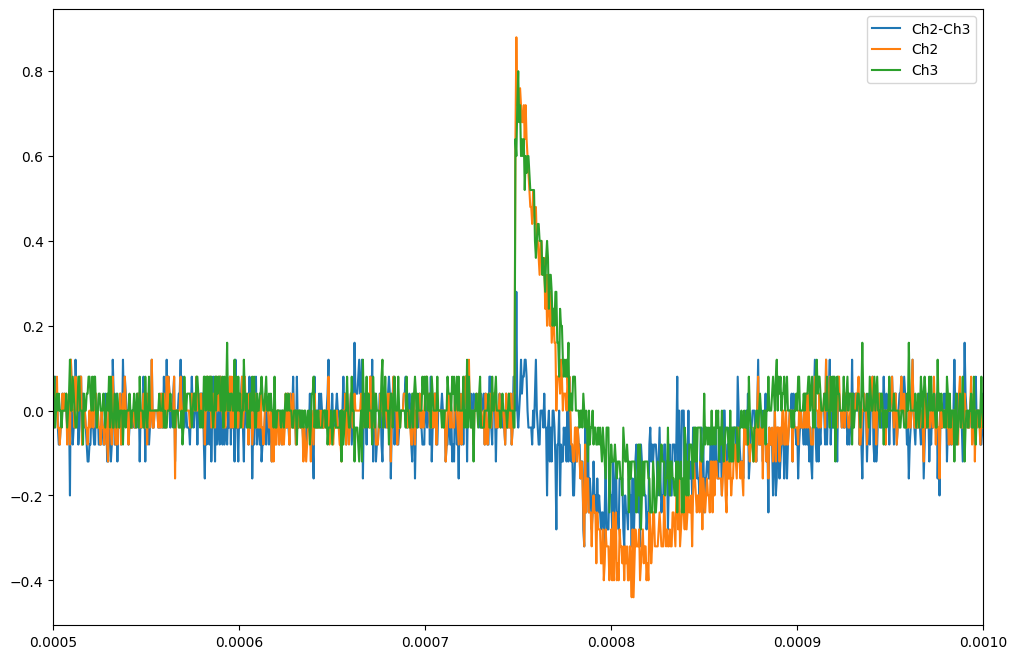

In [123]:
ShotN=211
timeMIN=6000
timeMAX=7000

dict_data = read_data(ShotN)
array_time = dict_data["pyro_time"]
array_data = dict_data["Ch2"]
array_data_EMP= dict_data["Ch3"]

fig, axs = plt.subplots(figsize= (12,8))

plt.plot(array_time, array_data-array_data_EMP, label="Ch2-Ch3")
plt.plot(array_time, array_data, label ="Ch2")
plt.plot(array_time, array_data_EMP, label ="Ch3")

axs.set(xlim= (0.0005, 0.001))
plt.legend()
plt.show()


In [83]:
shot_min = 158
shot_max = 196
shots = np.arange(shot_min, shot_max)

#shot_number_bdot, bdot_maxs = zip(*read_lots_of_data(shots, "bdot", silent= True).items())
#bdot_maxs = [np.max(reading) for reading in bdot_maxs]

shot_number_pyro, Ch1 = zip(*read_lots_of_data(shots, "Ch1", silent= True).items()) # what does zip do exactly?
Ch1 = [np.abs(np.min(reading)) for reading in Ch1]
shot_number_pyro, Ch2 = zip(*read_lots_of_data(shots, "Ch2", silent= True).items())
Ch2 = [np.abs(np.min(reading)) for reading in Ch2]
shot_number_pyro, Ch3 = zip(*read_lots_of_data(shots, "Ch3", silent= True).items())
Ch3 = [np.abs(np.min(reading)) for reading in Ch3]
shot_number_pyro, Ch4 = zip(*read_lots_of_data(shots, "Ch4", silent= True).items())
Ch4 = [np.abs(np.min(reading)) for reading in Ch4]

#shot_number_Xray, Xray = zip(*read_lots_of_data(shots, "xray", silent= True).items())
#Xray = [np.sum(reading) for reading in Xray]

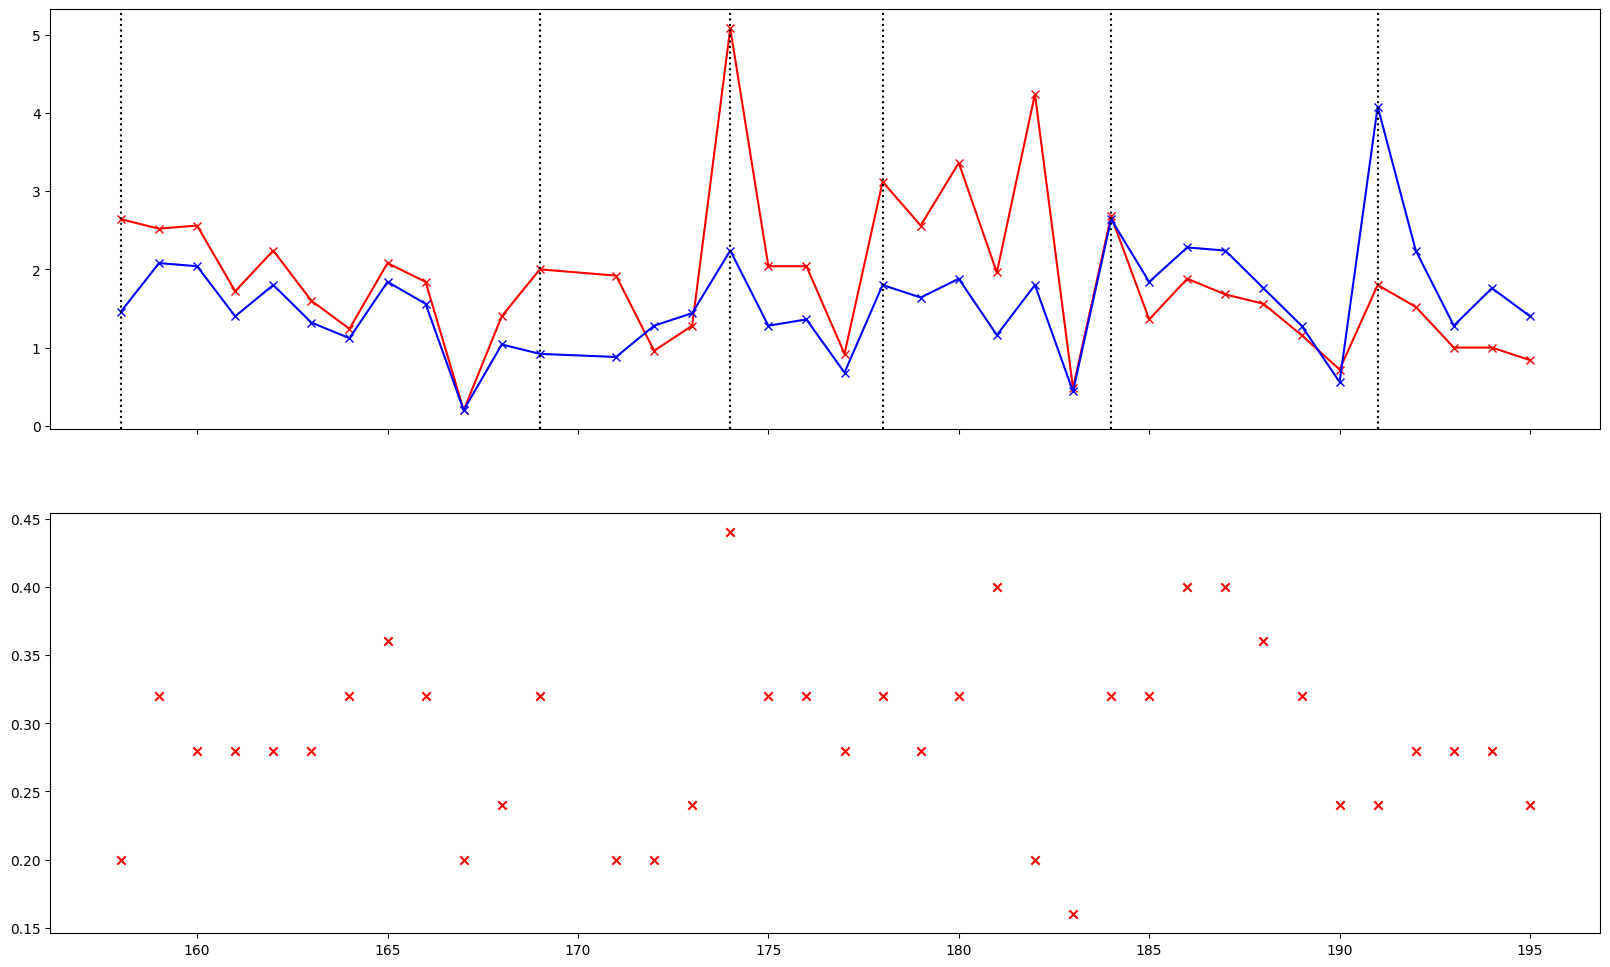

In [84]:
fig, axs = plt.subplots(2, 1, figsize= (20,12), sharex= True)

axs[0].plot(shot_number_pyro, Ch2, color="red", alpha=1, label="QMC pyro", marker="x")
axs[0].plot(shot_number_pyro, Ch3, color="blue", alpha=1, label="QMC pyro", marker="x")

axs[0].vlines([158,169,174,178,184,191], 0, 1, linestyles= "dotted", colors= "k", transform= axs[0].get_xaxis_transform())

axs[1].scatter(shot_number_pyro, Ch1, color="red", label="QMC pyro", marker="x")

plt.show()

In [85]:
shot_min = 211
shot_max = 236
shots = np.arange(shot_min, shot_max)

#shot_number_bdot, bdot_maxs = zip(*read_lots_of_data(shots, "bdot", silent= True).items())
#bdot_maxs = [np.max(reading) for reading in bdot_maxs]

shot_number_pyro, Ch1 = zip(*read_lots_of_data(shots, "Ch1", silent= True).items()) # what does zip do exactly?
Ch1 = [np.abs(np.min(reading)) for reading in Ch1]
shot_number_pyro, Ch2 = zip(*read_lots_of_data(shots, "Ch2", silent= True).items())
Ch2 = [np.abs(np.min(reading)) for reading in Ch2]
shot_number_pyro, Ch3 = zip(*read_lots_of_data(shots, "Ch3", silent= True).items())
Ch3 = [np.abs(np.min(reading)) for reading in Ch3]
shot_number_pyro, Ch4 = zip(*read_lots_of_data(shots, "Ch4", silent= True).items())
Ch4 = [np.abs(np.min(reading)) for reading in Ch4]

#shot_number_Xray, Xray = zip(*read_lots_of_data(shots, "xray", silent= True).items())
#Xray = [np.sum(reading) for reading in Xray]

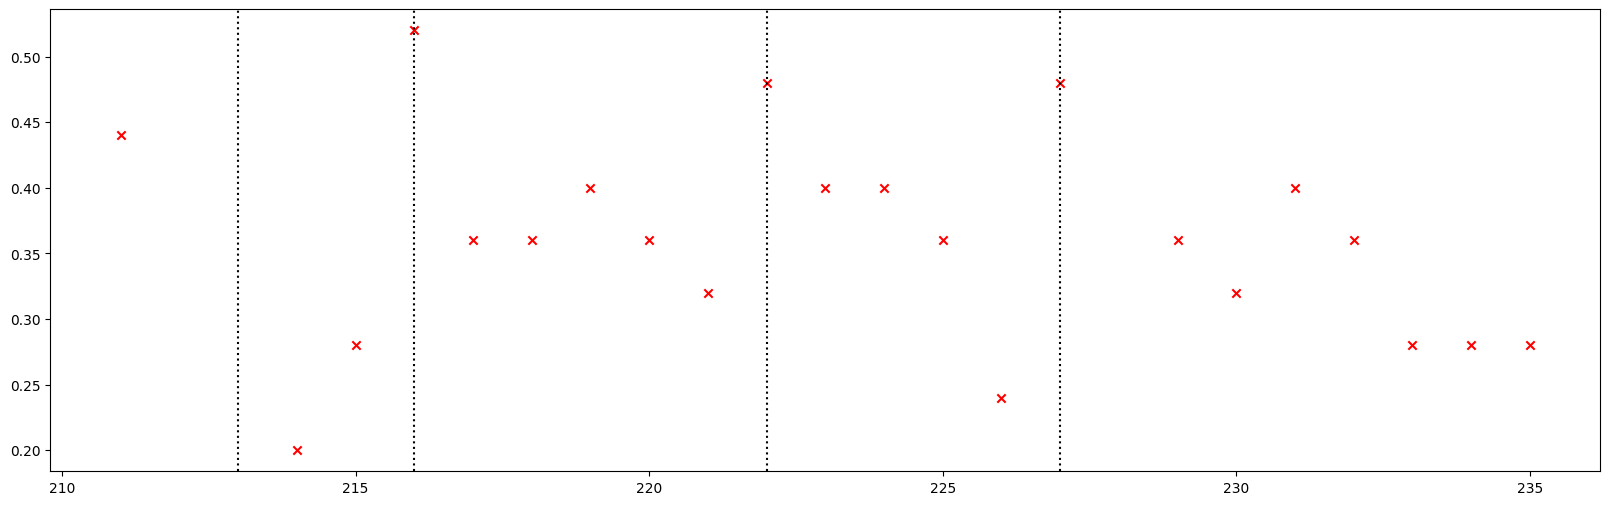

In [86]:
fig, axs = plt.subplots(figsize= (20, 6))

axs.scatter(shot_number_pyro, Ch2, color="red", label="QMC pyro", marker="x")
axs.vlines([213,216,222,227], 0, 1, linestyles ="dotted", colors ="k", transform= axs.get_xaxis_transform())

plt.show()

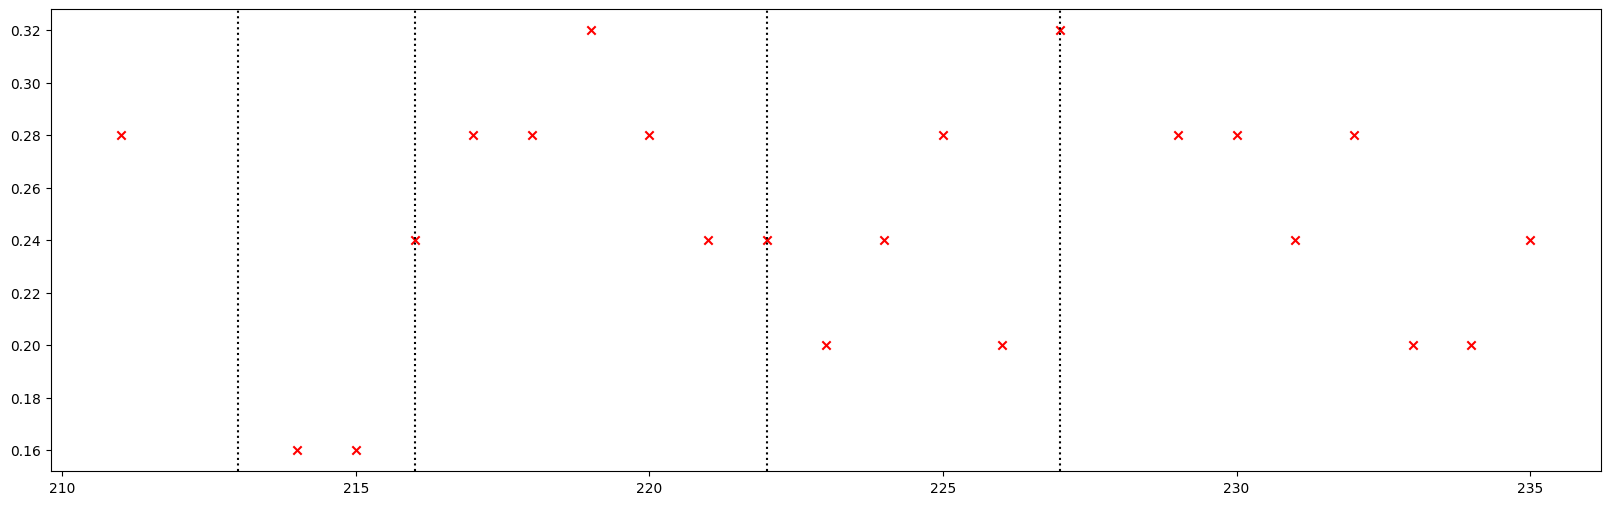

In [87]:
fig, axs = plt.subplots(figsize= (20,6))

axs.scatter(shot_number_pyro, Ch3, color="red", alpha=1, label="QMC pyro", marker="x")
axs.vlines([213, 216, 222, 227], 0, 1, linestyles ="dotted", colors ="k", transform= axs.get_xaxis_transform())

plt.show()

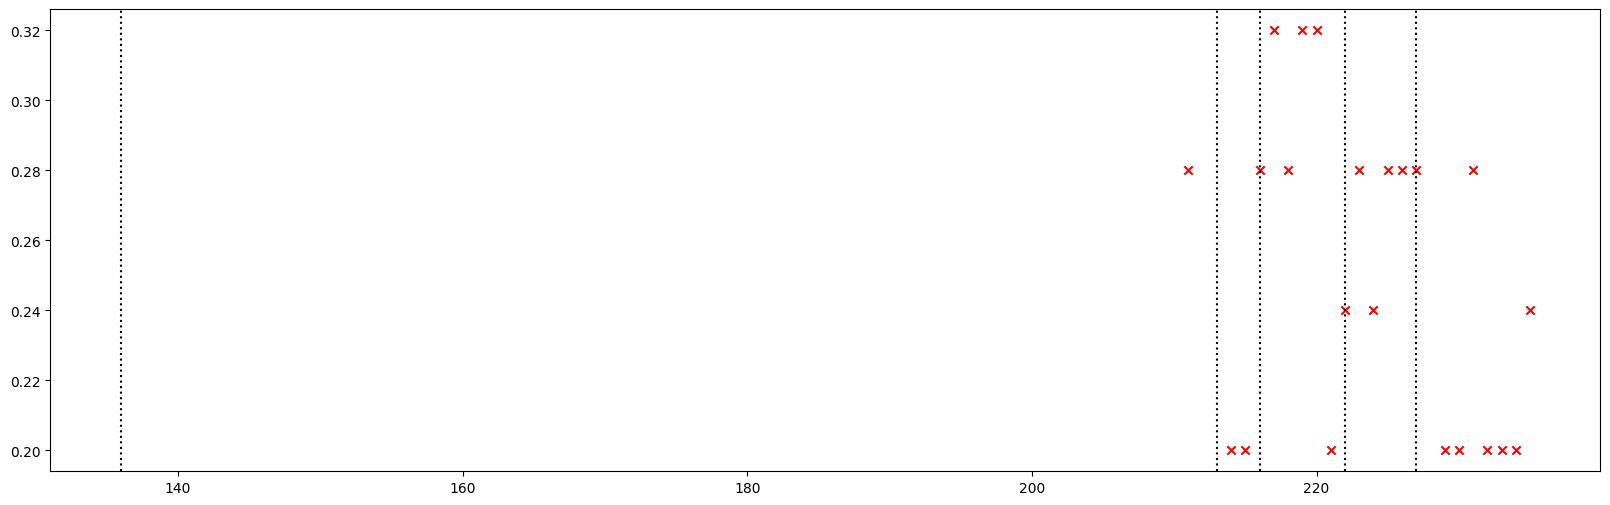

In [88]:
fig, axs = plt.subplots(figsize= (20,6))

axs.scatter(shot_number_pyro, Ch1, color="red", label="QMC pyro", marker="x")
axs.vlines([136,213,216,222,227], 0, 1, linestyles ="dotted", colors ="k", transform= axs.get_xaxis_transform())

plt.show()

In [89]:
laseren= np.array([0.969,0.954,0.91,0.927,0.856,0.905,0.872,0.812,0.838,0.767,0.834,0.835,0.815,0.838,0.811,0.774,0.824,0.835,0.774,0.804,0.757,0.759,0.798,0.725,0.768,0.67,0.637,0.677, 0.644,0.609])
laseren_shot_no = np.arange(107,137)

print(laseren.shape, laseren_shot_no.shape)
print(shot_number_pyro)
print(len(shot_number_pyro))

(30,) (30,)
(211, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235)
22


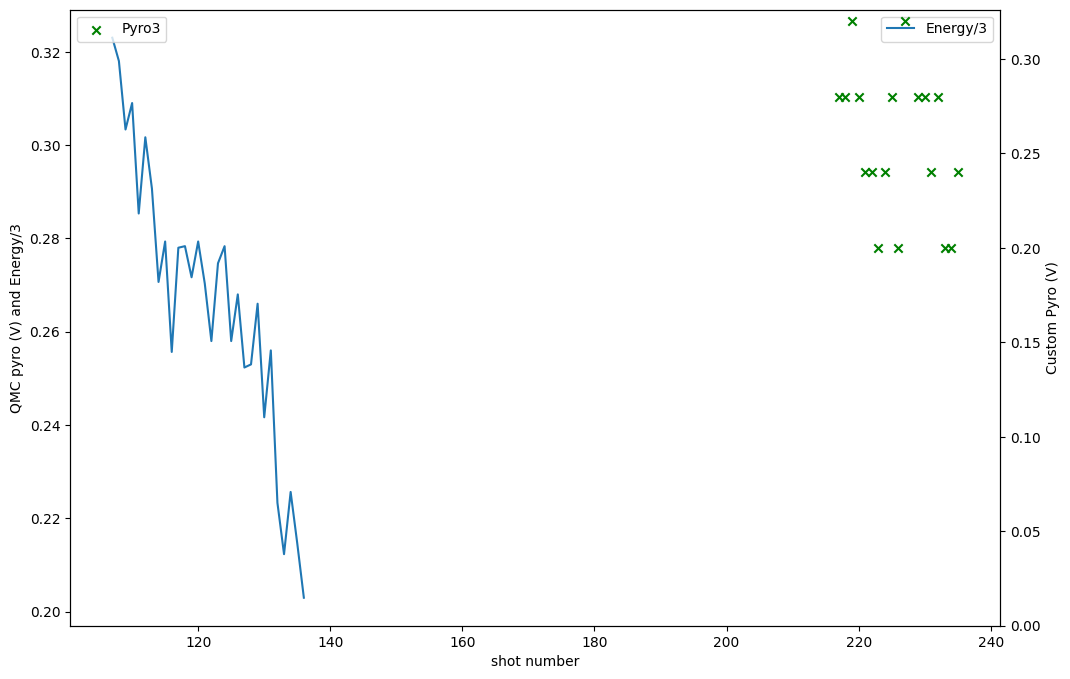

In [90]:
fig, axs = plt.subplots(figsize= (12,8))

axs.plot(laseren_shot_no, laseren/3, label="Energy/3")
axs.set(xlabel= "shot number", ylabel= "QMC pyro (V) and Energy/3")
plt.legend()

twinax = axs.twinx()
twinax.scatter(shot_number_pyro[4:], Ch3[4:], color="green", alpha=1, label="Pyro3",marker="x")
twinax.set(xlabel= "shot number", ylabel= "Custom Pyro (V)", ylim= (0,None))
plt.legend()
plt.show()

Found 4 files:
   290124WIRESHOT113000_Ch1.csv
   290124WIRESHOT113000_Ch2.csv
   290124WIRESHOT113000_Ch3.csv
   290124WIRESHOT113000_Ch4.csv


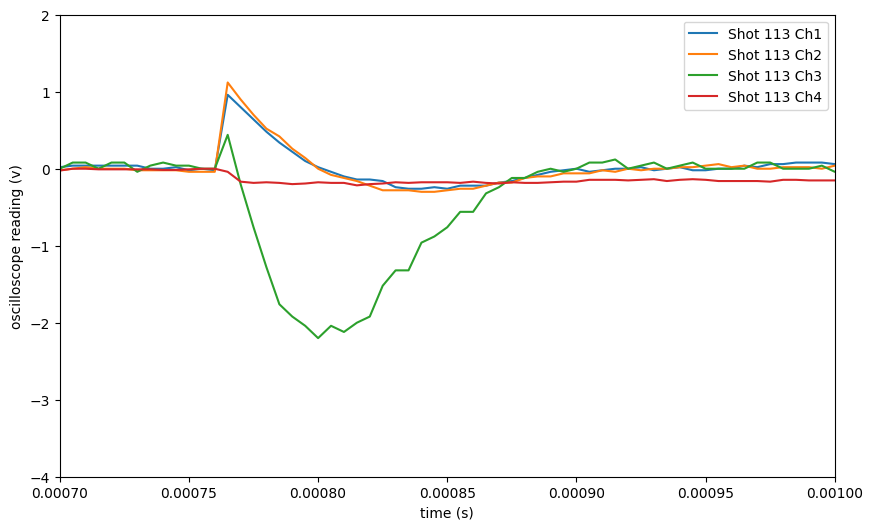

In [91]:
shoN=113

shot_data = read_data(shoN)

fig, axs = plt.subplots(figsize= (10,6))
for ch in ["Ch1","Ch2","Ch3","Ch4"]:
    plt.plot(shot_data["pyro_time"], shot_data[ch], label= "Shot {0:} {1:}".format(shoN, ch))

axs.set(xlim= (0.0007, 0.001), xlabel= "time (s)", ylabel= "oscilloscope reading (v)", ylim= (-4, 2))
plt.legend()
plt.show()

Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv


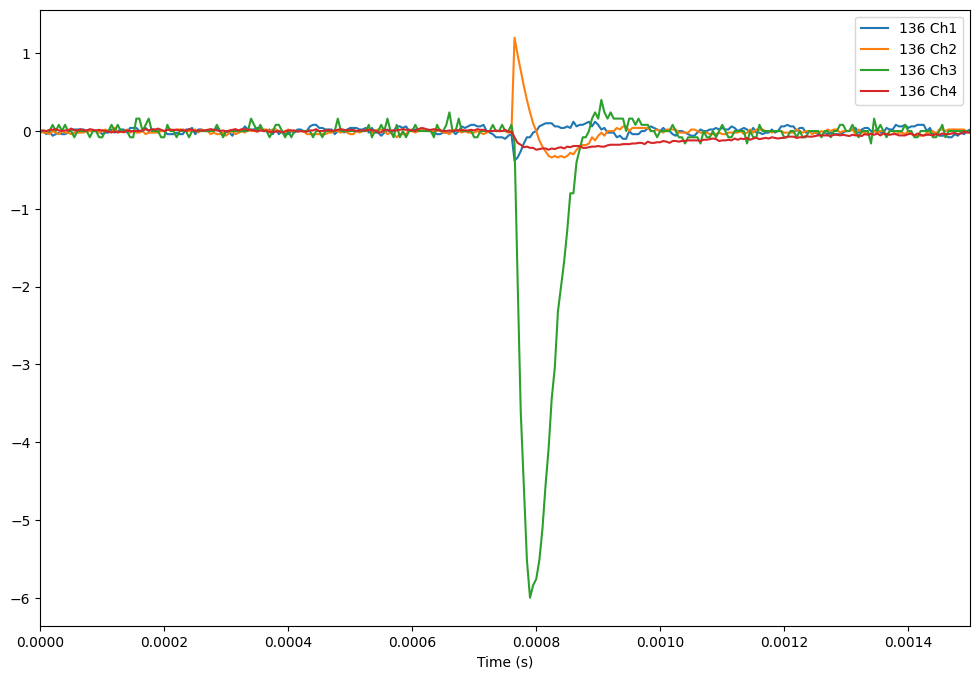

In [92]:
shoN=136

dict_data = read_data(shoN)
array_data_ch1 = dict_data["Ch1"]
array_data_EMP = dict_data["Ch2"]
array_data_ch3 = dict_data["Ch3"]
array_data_ch4 = dict_data["Ch4"]
array_time = dict_data["pyro_time"]

fig, axs = plt.subplots(figsize= (12,8))

axs.plot(array_time, array_data_ch1 -array_data_EMP, label="{:d} Ch1".format(shoN))
axs.plot(array_time, array_data_EMP, label="{:d} Ch2".format(shoN))
axs.plot(array_time, array_data_ch3, label="{:d} Ch3".format(shoN))
axs.plot(array_time, array_data_ch4, label="{:d} Ch4".format(shoN))

axs.set(xlabel= "Time (s)", xlim= (0, 0.0015))

plt.legend()
plt.show()

Found 4 files:
   290124WIRESHOT110000_Ch1.csv
   290124WIRESHOT110000_Ch2.csv
   290124WIRESHOT110000_Ch3.csv
   290124WIRESHOT110000_Ch4.csv


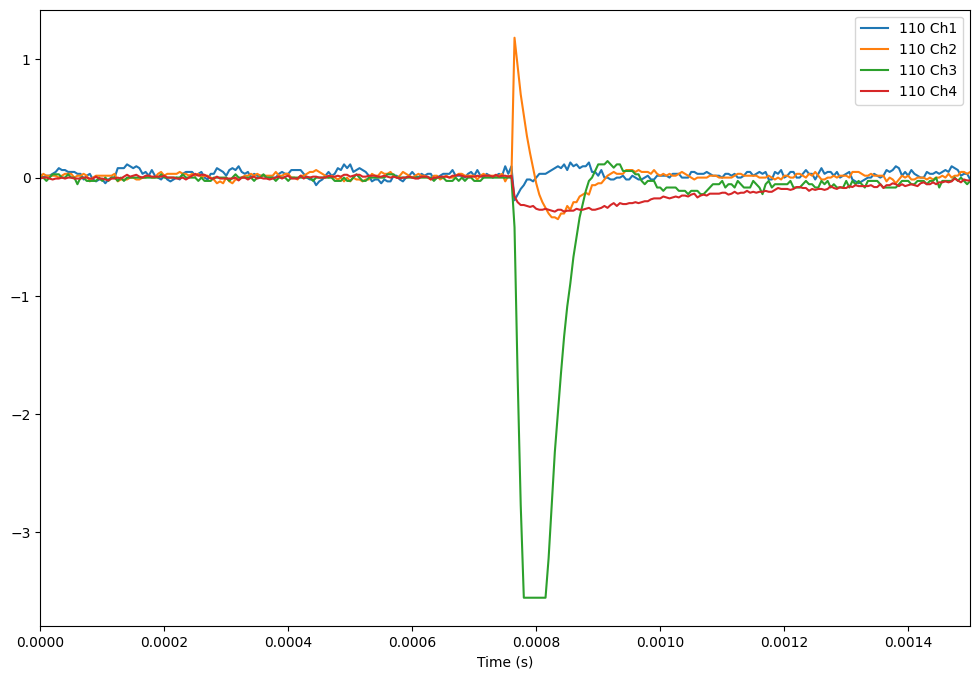

In [93]:
shoN=110
dict_data = read_data(shoN)
array_data_ch1 = dict_data["Ch1"]
array_data_EMP = dict_data["Ch2"]
array_data_ch3 = dict_data["Ch3"]
array_data_ch4 = dict_data["Ch4"]
array_time = dict_data["pyro_time"]

fig, axs = plt.subplots(figsize= (12,8))

axs.plot(array_time, array_data_ch1 -array_data_EMP, label="{:d} Ch1".format(shoN))
axs.plot(array_time, array_data_EMP, label="{:d} Ch2".format(shoN))
axs.plot(array_time, array_data_ch3, label="{:d} Ch3".format(shoN))
axs.plot(array_time, array_data_ch4, label="{:d} Ch4".format(shoN))

axs.set(xlabel= "Time (s)", xlim= (0, 0.0015))

plt.legend()
plt.show()

In [94]:
shot_min = 107
shot_max = 137
shots = np.arange(shot_min, shot_max)

#shot_number_bdot, bdot_maxs = zip(*read_lots_of_data(shots, "bdot", silent= True).items())
#bdot_maxs = [np.max(reading) for reading in bdot_maxs]

shot_number_pyro, Ch1 = zip(*read_lots_of_data(shots, "Ch1", silent= True).items()) # what does zip do exactly?
Ch1 = [np.abs(np.min(reading)) for reading in Ch1]
shot_number_pyro, Ch2 = zip(*read_lots_of_data(shots, "Ch2", silent= True).items())
Ch2 = [np.abs(np.min(reading)) for reading in Ch2]
shot_number_pyro, Ch3 = zip(*read_lots_of_data(shots, "Ch3", silent= True).items())
Ch3 = [np.abs(np.min(reading)) for reading in Ch3]
shot_number_pyro, Ch4 = zip(*read_lots_of_data(shots, "Ch4", silent= True).items())
Ch4 = [np.abs(np.min(reading)) for reading in Ch4]

#shot_number_Xray, Xray = zip(*read_lots_of_data(shots, "xray", silent= True).items())
#Xray = [np.sum(reading) for reading in Xray]

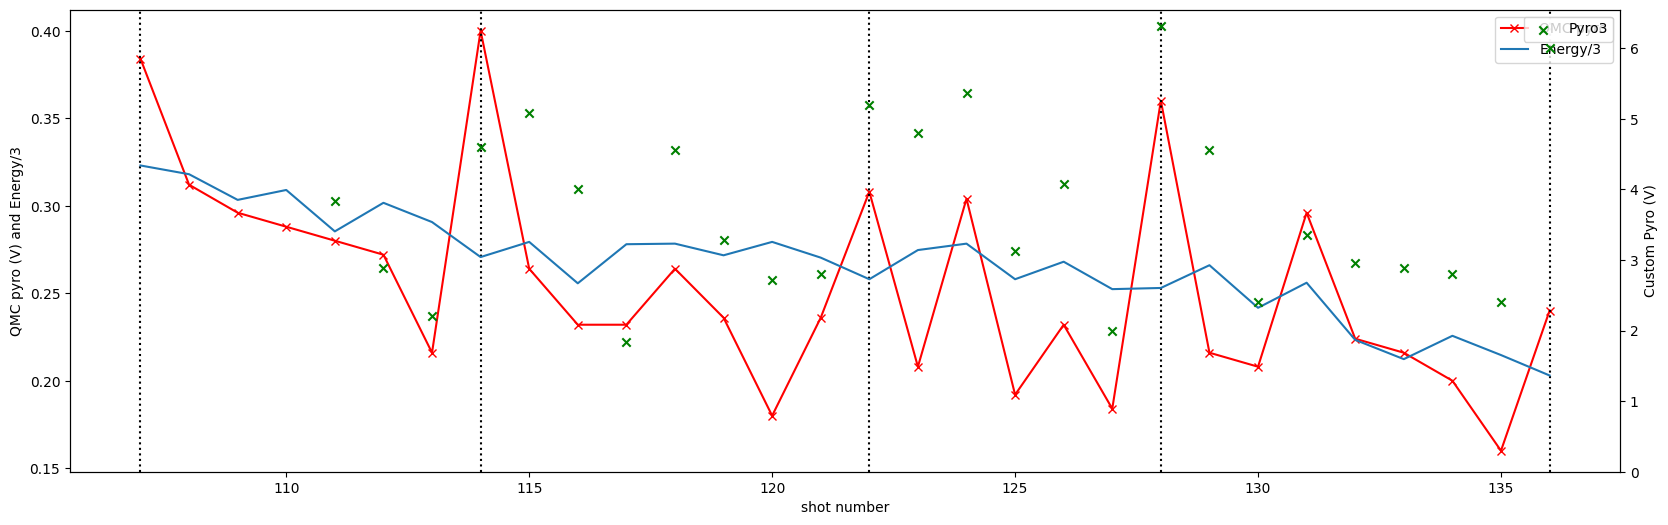

In [95]:
fig, axs = plt.subplots(figsize=(20,6))

axs.plot(shot_number_pyro, Ch4, color="red", label="QMC pyro", marker="x")
axs.vlines([107,114,122,128,136], 0, 1, linestyles ="dotted", colors ="k", transform= axs.get_xaxis_transform())
axs.plot(shot_number_pyro, laseren/3, label="Energy/3")
axs.set(ylabel = "QMC pyro (V) and Energy/3", xlabel= "shot number")
plt.legend()

twinax = axs.twinx()
twinax.scatter(shot_number_pyro[4:], Ch3[4:], color="green", alpha=1, label="Pyro3",marker="x")
twinax.set(xlabel= "shot number", ylabel= "Custom Pyro (V)", ylim= (0, None))
plt.legend()
plt.show()

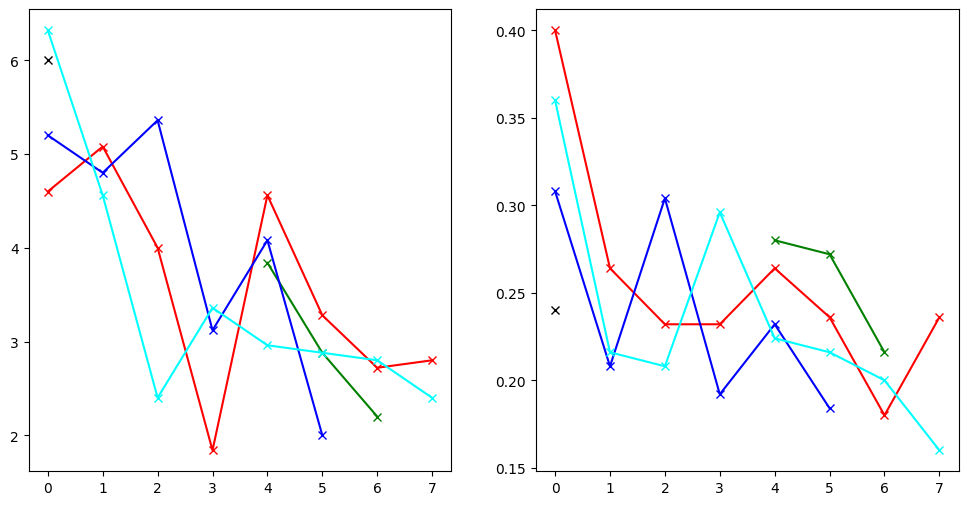

In [96]:
fig, axs = plt.subplots(1, 2, figsize= (12,6))

adj=[4,5,6]
axs[0].plot(adj,Ch3[4:7], color="green", marker="x")
axs[0].plot(Ch3[7:15], color="red", marker="x")
axs[0].plot(Ch3[15:21], color="blue", marker="x")
axs[0].plot(Ch3[21:29], color="cyan", marker="x")
axs[0].plot(Ch3[29:31], color="black", marker="x")


axs[1].plot(adj,Ch4[4:7], color="green", marker="x")
axs[1].plot(Ch4[7:15], color="red", marker="x")
axs[1].plot(Ch4[15:21], color="blue", marker="x")
axs[1].plot(Ch4[21:29], color="cyan", marker="x")
axs[1].plot(Ch4[29:31], color="black", marker="x")

plt.show()

Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif


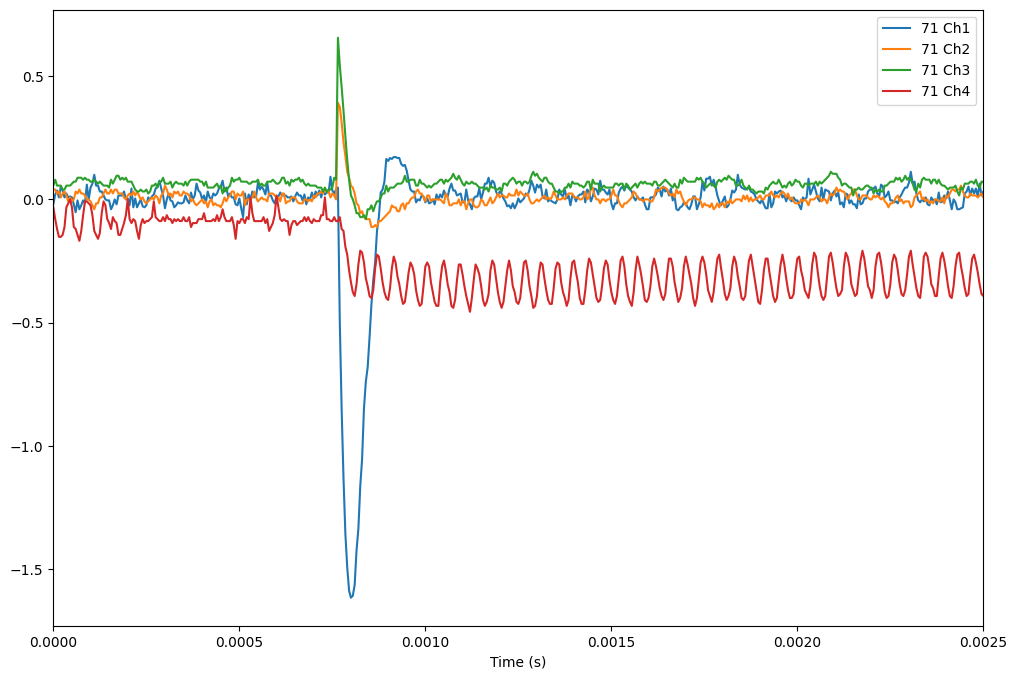

In [97]:
shoN=71
dict_data = read_data(shoN)
array_data_ch1 = dict_data["Ch1"]
array_data_EMP = dict_data["Ch2"]
array_data_ch3 = dict_data["Ch3"]
array_data_ch4 = dict_data["Ch4"]
array_time = dict_data["pyro_time"]

fig, axs = plt.subplots(figsize= (12,8))

axs.plot(array_time, array_data_ch1 -array_data_EMP, label="{:d} Ch1".format(shoN))
axs.plot(array_time, array_data_EMP, label="{:d} Ch2".format(shoN))
axs.plot(array_time, array_data_ch3, label="{:d} Ch3".format(shoN))
axs.plot(array_time, array_data_ch4, label="{:d} Ch4".format(shoN))

axs.set(xlabel= "Time (s)", xlim= (0, 0.0025))

plt.legend()
plt.show()

In [98]:
shot_min = 71
shot_max = 76
shots = np.arange(shot_min, shot_max)

shot_number_bdot, bdot_maxs = zip(*read_lots_of_data(shots, "bdot", silent= True).items())
bdot_maxs = [np.max(reading) for reading in bdot_maxs]

shot_number_pyro, pyro_mins = zip(*read_lots_of_data(shots, "Ch1", silent= True).items())
pyro_mins = np.array([np.abs(np.min(reading)) for reading in pyro_mins])
shot_number_pyro, Ch2 = zip(*read_lots_of_data(shots, "Ch2", silent= True).items())
Ch2 = [np.max(reading) for reading in Ch2]
#shot_number_pyro, Ch3 = zip(*read_lots_of_data(shots, "Ch3", silent= True).items())
#Ch3 = [np.abs(np.min(reading)) for reading in Ch3]
#shot_number_pyro, Ch4 = zip(*read_lots_of_data(shots, "Ch4", silent= True).items())
#Ch4 = [np.abs(np.min(reading)) for reading in Ch4]

#shot_number_Xray, Xray = zip(*read_lots_of_data(shots, "xray", silent= True).items())
#Xray = [np.sum(reading) for reading in Xray]

print("Pyro mins " + str(pyro_mins))
print("Pyro maxs" + str(Ch2)) #somehow has more floating point errors than in Kirill's code

Pyro mins [1.56000004 1.32000004 1.60000004 1.08000004]
Pyro maxs[0.392000009, 0.328000008, 0.208000006, 0.112000005]


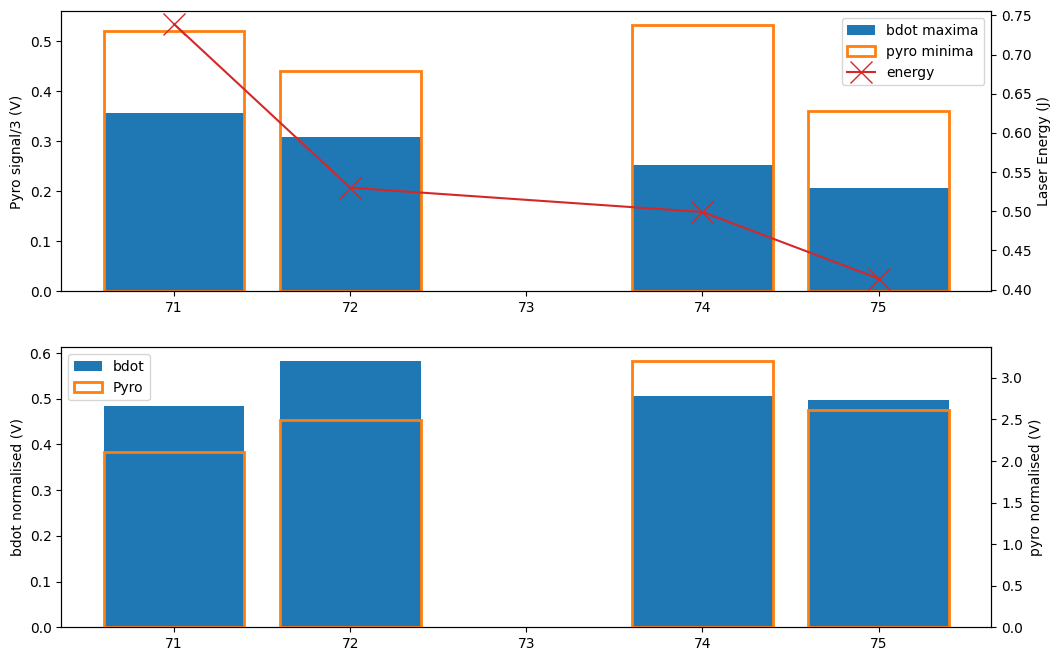

In [99]:
energies=[0.739,0.53,0.499,0.414]

fig, axs = plt.subplots(2, 1, figsize= (12,8))

line1 = axs[0].bar(shot_number_bdot, bdot_maxs, color= "tab:blue", label= "bdot maxima")
line2 = axs[0].bar(shot_number_pyro, pyro_mins/3, color= "None", edgecolor= "tab:orange", linewidth= 2, label= "pyro minima")
axs[0].set(ylabel= "Pyro signal/3 (V)")

twinax1 = axs[0].twinx()
line3 = twinax1.plot(shot_number_pyro, energies, marker= "x", markersize= 16, color= "tab:red", label= "energy")
twinax1.set(xlabel= "shot number", ylabel= "Laser Energy (J)")

lines1 = [line1, line2, *line3]
labels1 = [line.get_label() for line in lines1]
axs[0].legend(lines1, labels1)


bdot_norm = np.divide(bdot_maxs, energies)
pyro_mins_norm = pyro_mins/energies

line4 = axs[1].bar(shot_number_bdot, bdot_norm, color="tab:blue", label="bdot")
axs[1].set(ylabel= "bdot normalised (V)")

twinax2 = axs[1].twinx()
line5 = twinax2.bar(shot_number_pyro, pyro_mins_norm, color= "None", edgecolor= "tab:orange", linewidth= 2, label="Pyro")
twinax2.set(xlabel= "shot number", ylabel= "pyro normalised (V)")

lines2 = [line4, line5]
labels2 = [line.get_label() for line in lines2]
axs[1].legend(lines2, labels2)

plt.show()

In [117]:
shot_min = 71
shot_max = 76
shots = np.arange(shot_min, shot_max)

shot_number_bdot, bdot_maxs = zip(*read_lots_of_data(shots, "bdot", silent= True).items())
bdot_maxs = [np.max(reading) for reading in bdot_maxs]

shot_number_pyro, Ch1 = zip(*read_lots_of_data(shots, "Ch1", silent= True).items())
Ch1 = [np.abs(np.min(reading)) for reading in Ch1]
shot_number_pyro, Ch2 = zip(*read_lots_of_data(shots, "Ch2", silent= True).items())
Ch2 = [np.abs(np.max(reading)) for reading in Ch2]
shot_number_pyro, Ch3 = zip(*read_lots_of_data(shots, "Ch3", silent= True).items())
Ch3 = [np.abs(np.max(reading)) for reading in Ch3]
shot_number_pyro, Ch4 = zip(*read_lots_of_data(shots, "Ch4", silent= True).items())
Ch4 = [np.abs(np.min(reading)) for reading in Ch4]

shot_number_Xray, Xray = zip(*read_lots_of_data(shots, "xray", silent= True).items())
Xray = [np.sum(reading) for reading in Xray]

71
72
74
75
Found 4 files:
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 16_07_26 SHOT72.tif
   2024 janvier 26 16_22_21 SHOT74.tif
   2024 janvier 26 16_28_44 SHOT75.tif


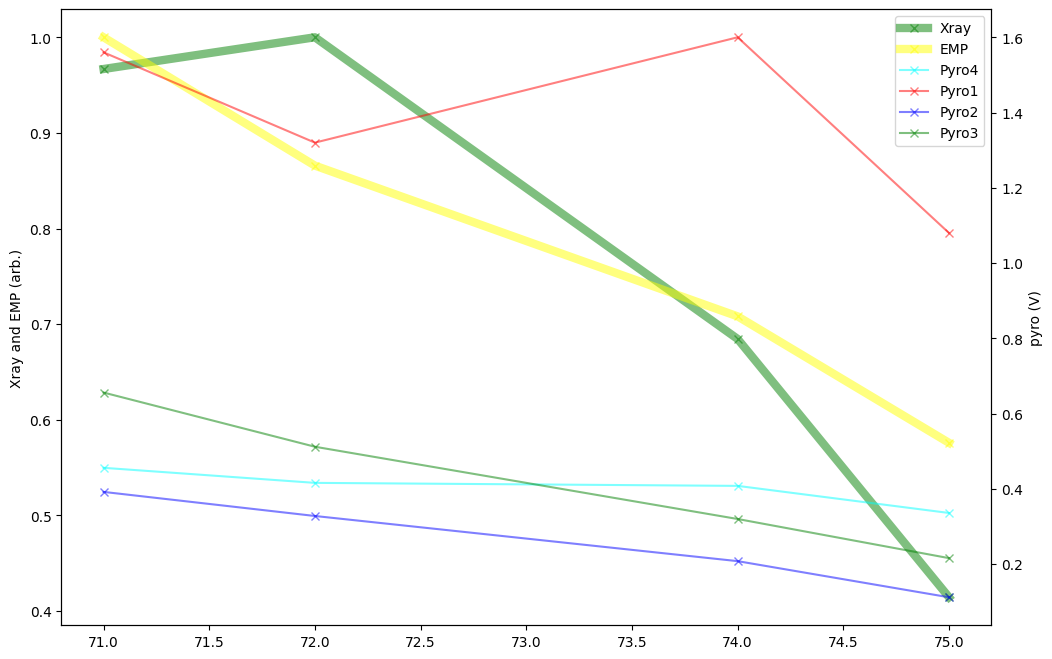

In [116]:
fig, axs = plt.subplots(figsize= (12,8))

line1 = axs.plot(shot_number_Xray, Xray/np.max(Xray), color="green", alpha=0.5, label="Xray", marker="x", linewidth=6.0)
line2 = axs.plot(shot_number_bdot, bdot_maxs/np.max(bdot_maxs), color="yellow", alpha=0.5, label="EMP", marker="x", linewidth=6.0)
axs.set(ylabel ="Xray and EMP (arb.)")

twinax = axs.twinx()
line3 = twinax.plot(shot_number_pyro, Ch4, color="cyan", alpha=0.5, label="Pyro4", marker="x")
line4 = twinax.plot(shot_number_pyro, Ch1, color="red", alpha=0.5, label="Pyro1", marker="x")
line5 = twinax.plot(shot_number_pyro, Ch2, color="blue", alpha=0.5, label="Pyro2",marker="x")
line6 = twinax.plot(shot_number_pyro, Ch3, color="green", alpha=0.5, label="Pyro3",marker="x")
twinax.set(xlabel= "shot number", ylabel= "pyro (V)")

lines = [*line1, *line2, *line3, *line4, *line5, *line6]
labels = [line.get_label() for line in lines]
axs.legend(lines, labels)

plt.show()